In [756]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pyxu.operator as pxop
import pyxu.opt.solver as pxls

import scipy.fft as sfft
import scipy.signal as sig

from pyxu.opt.stop import RelError, MaxIter
from pyxu.abc import QuadraticFunc
import pyxu.util as pxu
from matplotlib import use
# use("Qt5Agg")

#image model
seed = 746
Ngrid = 800
ds_factor = 8
Nmeas = Ngrid // ds_factor
k = 10
fgbgR = 10.
ongrid = True
r12 = 2.  # rate between l2 norm of fg observations and bg observations

lambda1_factor = 0.2
lambda2 = 1e-3 * Ngrid
eps = 1e-5

blasso_factor = 0.3


In [757]:
# measurement model
kernel_std_int = 3 * ds_factor
kernel_std = kernel_std_int / Ngrid  # Gaussian kernel std
kernel_std = 0.02
kernel_std_int = np.floor(kernel_std*Ngrid).astype(int)
print(kernel_std, kernel_std_int)
kernel_width = 3 * 2 * kernel_std_int + 1  # Length of the Gaussian kernel
snrdb_meas = 10

0.02 16


In [758]:
if seed is None:
    seed = np.random.randint(1000)
rng = np.random.default_rng(seed=seed)

img = np.zeros((Ngrid,))
if ongrid:
    Neff = int(.5 * Ngrid)
    idx = rng.choice(Neff, k, replace=False)
    indices = idx + int(.25 * Ngrid)
    img[indices] = rng.uniform(1, fgbgR, k)


In [759]:
# PSNR : 10 * np.log10(max(img)**2 / np.std(noise)**2) = 20 * log10(max(img) / std(noise))
bg_impulses = np.zeros((Ngrid,))
# kernel_std_bg_int = 5 * kernel_std_int
# kernel_std_bg = kernel_std_bg_int / Ngrid
kernel_std_bg = 5 * kernel_std
kernel_std_bg_int = np.floor(kernel_std_bg*Ngrid).astype(int)
if ongrid:
    kk = 2*k  # 2
    idx = rng.choice(Neff, kk, replace=False)
    indices = idx + int(.25 * Ngrid)
    bg_impulses[indices] = 1 + rng.uniform(-.5, .5, kk)
    kernel_width_bg = 3 * 2 * kernel_std_bg_int + 1
    kernel_bg_1d = np.exp(-0.5 * ((np.arange(kernel_width_bg) - (kernel_width_bg - 1) / 2) ** 2) / ((kernel_std_bg*Ngrid) ** 2))
    norm_bg1d = (np.sqrt(2 * np.pi) * kernel_std_bg)
    kernel_bg_1d /= norm_bg1d
    background = np.convolve(np.pad(bg_impulses, (kernel_width_bg//2, kernel_width_bg//2), mode='constant'), kernel_bg_1d, mode='valid')

    # background = sig.fftconvolve(bg_impulses, kernel_bg_1d, mode='same')

In [760]:
kernel_measurement = np.exp(-0.5 * ((np.arange(kernel_width) - (kernel_width - 1) / 2) ** 2) / ((kernel_std*Ngrid) ** 2))
norm_meas = (np.sqrt(2 * np.pi) * kernel_std)

kernel_measurement /= norm_meas

In [761]:
print(norm_meas)
kernel_measurement.sum()

0.050132565492620004


798.0548335115787

In [762]:
# plt.figure()
# plt.scatter(np.arange(kernel_width)/Ngrid, kernel_measurement)
# plt.show()

In [763]:
conv_fg = np.convolve(np.pad(img, (kernel_width//2, kernel_width//2), mode='constant'), kernel_measurement, mode='valid')
meas_fg = conv_fg[ds_factor//2::ds_factor]

# std_meas_bg2_int = kernel_std_int**2 + kernel_std_bg_int**2
std_meas_bg2 = kernel_std**2 + kernel_std_bg**2
std_meas_bg2_int = np.floor(np.sqrt(std_meas_bg2)*Ngrid).astype(int)
width_meas_bg = 3 * 2 * std_meas_bg2_int + 1

# Next formula could be verified -> Done
kernel_meas_bg = ( kernel_std * kernel_std_bg * np.sqrt(2 * np.pi / std_meas_bg2) *
                  np.exp(-0.5 * ((np.arange(width_meas_bg) - (width_meas_bg - 1) / 2) ** 2) / (std_meas_bg2*(Ngrid**2))))
kernel_meas_bg /= (norm_meas * norm_bg1d)

# kernel_meas_bg = np.exp(-0.5 * ((np.arange(width_meas_bg) - (width_meas_bg - 1) / 2) ** 2) / (std_meas_bg2*Ngrid**2))
# kernel_meas_bg /= (np.sqrt(2 * np.pi) * np.sqrt(std_meas_bg2))
#
# print(np.allclose(kernel_meas_bg, kernel_meas_bg1))

In [764]:
print(np.linalg.norm(meas_fg))
print(kernel_std, kernel_std_bg, std_meas_bg2**.5)

1195.7718932739488
0.02 0.1 0.10198039027185571


In [765]:
# plt.figure()
# plt.scatter(np.arange(width_meas_bg)/Ngrid, kernel_meas_bg)
# plt.show()

In [766]:
conv_bg = np.convolve(np.pad(bg_impulses, (width_meas_bg//2, width_meas_bg//2), mode='constant'),
                                           kernel_meas_bg, mode='valid')
meas_bg = conv_bg[ds_factor//2::ds_factor]

print(np.linalg.norm(meas_bg))

219.72802623369924


In [767]:

if r12:
    factor = r12 * np.linalg.norm(meas_bg) / np.linalg.norm(meas_fg)
    img *= factor
    meas_fg *= factor

x = img + background
noiseless_y = meas_fg + meas_bg

sigma_noise = np.linalg.norm(noiseless_y)/Nmeas * 10**(-snrdb_meas / 20)
noise_meas = rng.normal(0, sigma_noise, noiseless_y.shape)
y = noiseless_y + noise_meas

In [768]:
factor

0.3675082638580802

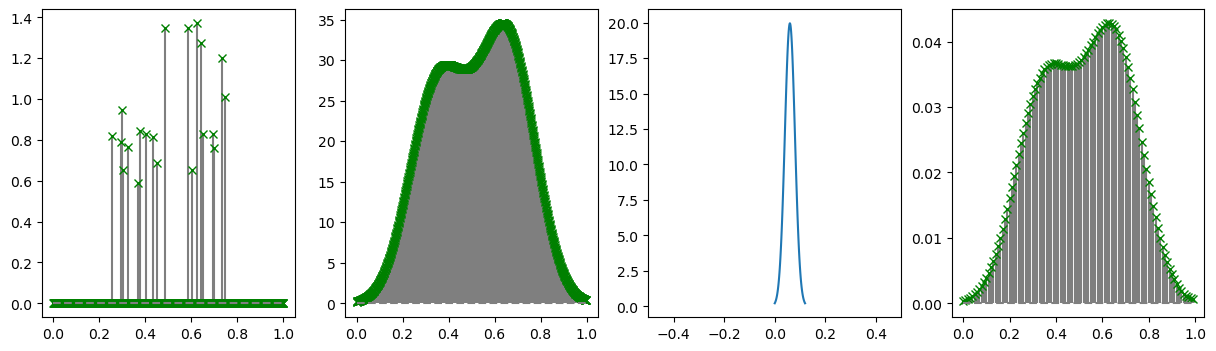

798.0548335115787


In [769]:
locs = np.arange(800)/Ngrid
plt.figure(figsize=(15, 4))
plt.subplot(141)
plt.stem(locs, bg_impulses, basefmt="C7--", linefmt="C7-", markerfmt='gx')
plt.subplot(142)
plt.stem(locs, background, basefmt="C7--", linefmt="C7-", markerfmt='gx')
plt.subplot(143)
plt.plot(np.arange(kernel_width)/Ngrid, kernel_measurement)
plt.xlim([-.5,.5])
plt.subplot(144)
plt.stem(np.arange(100) * ds_factor/Ngrid, meas_bg/800, basefmt="C7--", linefmt="C7-", markerfmt='gx')
plt.show()

print(kernel_measurement.sum())
# plt.figure()
# plt.scatter(np.arange(kernel_width)/Ngrid, kernel_measurement)
# plt.show()

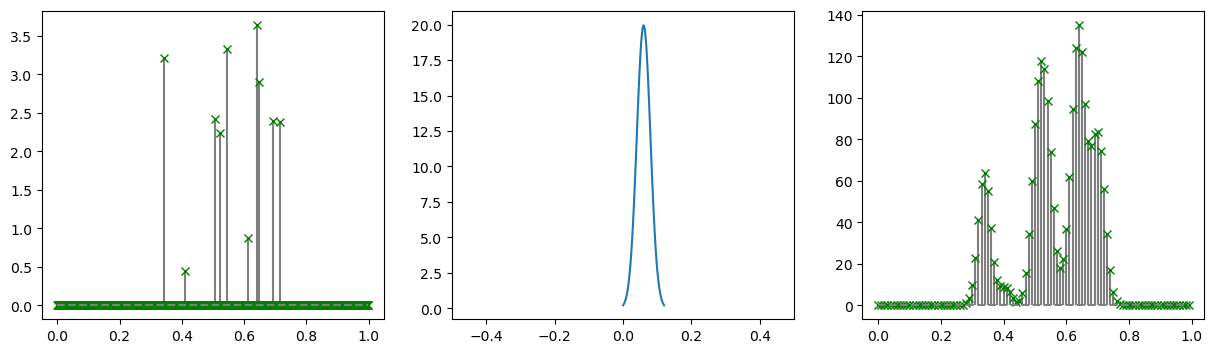

In [771]:
locs = np.arange(800)/Ngrid
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.stem(locs, img, basefmt="C7--", linefmt="C7-", markerfmt='gx')
plt.subplot(132)
plt.plot(np.arange(kernel_width)/Ngrid, kernel_measurement)
plt.xlim([-.5,.5])
plt.subplot(133)
plt.stem(np.arange(100) * ds_factor/Ngrid, meas_fg, basefmt="C7--", linefmt="C7-", markerfmt='gx')
plt.show()

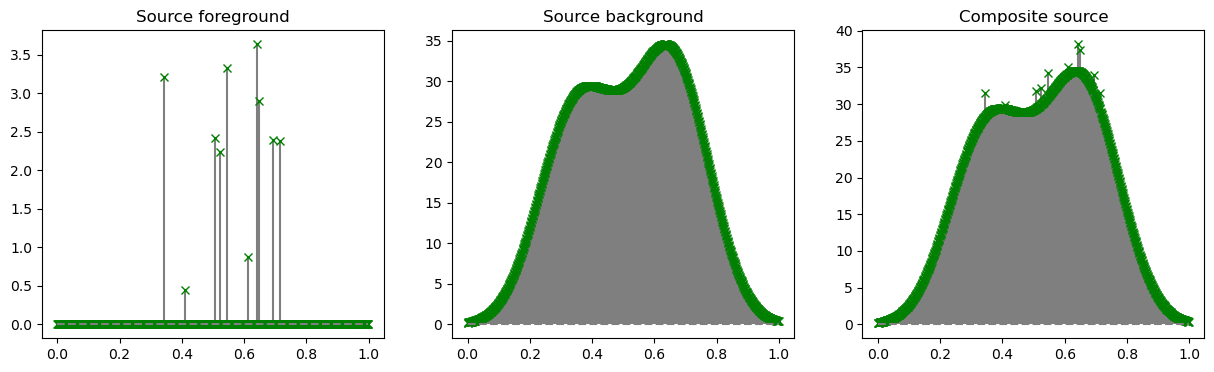

In [772]:
# yrange = [min(3*y.min(), y.min()-0.05), 1.05*y.max()]
locs = np.arange(800)/Ngrid
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.stem(locs, img, basefmt="C7--", linefmt="C7-", markerfmt='gx')
plt.title("Source foreground")
# plt.ylim(yrange)
plt.subplot(132)
plt.stem(locs, background, basefmt="C7--", linefmt="C7-", markerfmt='gx')
plt.title("Source background")
# plt.ylim(yrange)
plt.subplot(133)
plt.stem(locs, x, basefmt="C7--", linefmt="C7-", markerfmt='gx')
plt.title("Composite source")
# plt.ylim(yrange)
plt.show()

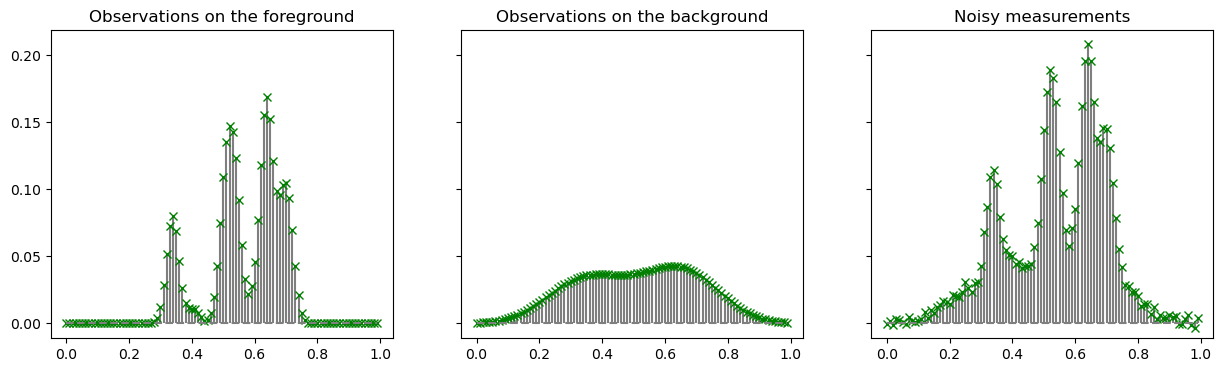

In [773]:
yrange = [min(3*y.min(), y.min()-0.05, -0.05), 1.05*y.max()]
yrange = [y/800 for y in yrange]
locs = np.arange(100) * ds_factor/Ngrid
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.stem(locs, meas_fg/800, basefmt="C7--", linefmt="C7-", markerfmt='gx')
plt.title("Observations on the foreground")
plt.ylim(yrange)
plt.subplot(132)
plt.stem(locs, meas_bg/800, basefmt="C7--", linefmt="C7-", markerfmt='gx')
plt.title("Observations on the background")
plt.ylim(yrange)
plt.subplot(133)
plt.stem(locs, y/800, basefmt="C7--", linefmt="C7-", markerfmt='gx')
plt.title("Noisy measurements")
plt.ylim(yrange)
fig = plt.gcf()
for ax in fig.axes:
    ax.label_outer()
plt.show()

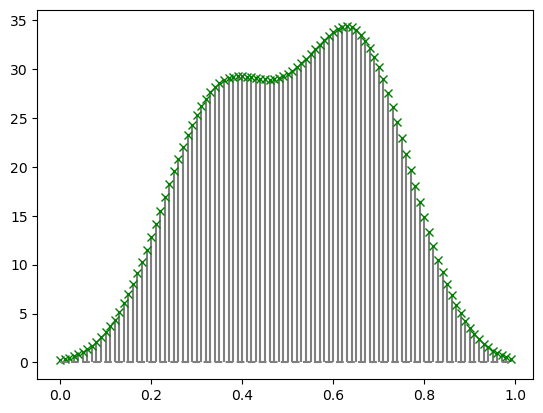

In [774]:
##### Honestly, I don't know what the following code means  #####

conv_sum = np.convolve(np.pad(x, (kernel_width//2, kernel_width//2), mode='constant'), kernel_measurement/800, mode='valid')
meas_sum = conv_sum[ds_factor//2::ds_factor]

locs = np.arange(100)*8/Ngrid
plt.figure()
plt.stem(locs, meas_sum, basefmt="C7--", linefmt="C7-", markerfmt='gx')
plt.show()

### Reconstruction now

In [775]:
diff_std2 = 2 * kernel_std**2
norm_regul = np.sqrt(2 * np.pi * diff_std2)
# xis = np.arange(ds_factor//2, Ngrid, ds_factor)
diffs = np.arange(0, 4 * np.sqrt(diff_std2)*Ngrid, ds_factor)
diffs = np.hstack([-diffs[1:][::-1], diffs])
kernel_regul = np.exp(-0.5 * ((diffs/Ngrid)**2)/diff_std2)
# kernel_regul *= kernel_std**2 / ( kernel_std_regul**2 * np.sqrt(2 * np.pi * diff_std2) )
kernel_regul /= norm_regul
M_kernel = kernel_regul/lambda2
M_kernel[M_kernel.shape[0]//2] += 1

regul_width = kernel_regul.shape[0]
h = np.zeros(Nmeas)
h[:regul_width] = M_kernel
h = np.roll(h, -regul_width//2 + 1)
hm1 = sfft.irfft(1/sfft.rfft(h))

Mlambda = pxop.Convolve(
    arg_shape=Nmeas,
    kernel=[M_kernel,],
    center=[M_kernel.shape[0]//2,],
    mode="wrap",
    enable_warnings=True,
)
MlambdaInv = pxop.Convolve(
    arg_shape=Nmeas,
    kernel=[hm1,],
    center=[0,],
    mode="wrap",  # constant
    enable_warnings=True,
)

MlambdaInv.lipschitz = MlambdaInv.estimate_lipschitz(method="svd", tol=1e-4)

In [776]:
# u = np.random.normal(size=100)
# np.allclose(MlambdaInv(Mlambda(u)), u), np.allclose(Mlambda(MlambdaInv(u)), u)

# res = np.convolve(np.pad(hm1, M_kernel.shape[0]//2, mode="wrap"), M_kernel, mode='valid')
# res[np.abs(res) < 1e-10] = 0
# res

In [788]:
#now define H
# Dimension: Ngrid -> Nmeas
fOp = pxop.Convolve(
    arg_shape=img.shape,
    kernel=[kernel_measurement,],
    center=[kernel_width // 2,],
    mode="wrap",  # constant
    enable_warnings=True,
)

fOp.lipschitz = fOp.estimate_lipschitz(method='svd', tol=1e-3)
ss = pxop.SubSample(Ngrid, slice(ds_factor//2, Ngrid, ds_factor))
Hop = ss * fOp

In [ ]:
lambda1max = np.abs(Hop.adjoint(MlambdaInv(y).ravel())).max()
lambda1 = lambda1_factor * lambda1max

loss = QuadraticFunc((1, Nmeas), Q=MlambdaInv).asloss(y.ravel()) * Hop
# loss.diff_lipschitz = loss.estimate_diff_lipschitz(method='svd')  # Mlambda.lipschitz  # fOp.lipschitz = 1.

regul = lambda1 * pxop.PositiveL1Norm(Ngrid)

stop_crit = RelError(eps=eps, var="x", f=None, norm=2, satisfy_all=True,) & MaxIter(10)

In [793]:
# print(fOp.lipschitz)
# print(loss._diff_lipschitz/800)
# loss.estimate_diff_lipschitz(method='svd')


798.0548335115786
799.2201488057678


634.2798419548415

In [800]:
# print(Mlambda.lipschitz)
# print(hm1.max()*800, np.abs(hm1).sum()*800)
# Mlambda.estimate_lipschitz(method='svd')

178.1831807091168
526.1991212821047 1391.0808336848963


125.99453537280448

In [778]:
# arr = np.zeros(100)
# arr[50] = 1.
# res = Hop.adjoint(arr)
#
# print(np.allclose(res[res != 0], kernel_measurement))

True


In [780]:
print("Decoupled solving...")
pgd = pxls.PGD(loss, g=regul, show_progress=False)
start = time.time()
pgd.fit(x0=np.zeros(img.size), stop_crit=stop_crit)
pgd_time = time.time() - start

_, hist = pgd.stats()
x1 = pgd.solution()

Mresiduals = MlambdaInv(y - Hop(x1))
tmp = np.zeros(Ngrid)
tmp[ds_factor//2::ds_factor] = Mresiduals
x2 = np.convolve(tmp, kernel_measurement, mode='same') / lambda2

Decoupled solving...


In [781]:
# np.allclose(Hop(img), meas_fg)

Text(0.5, 1.0, 'Recovered background')

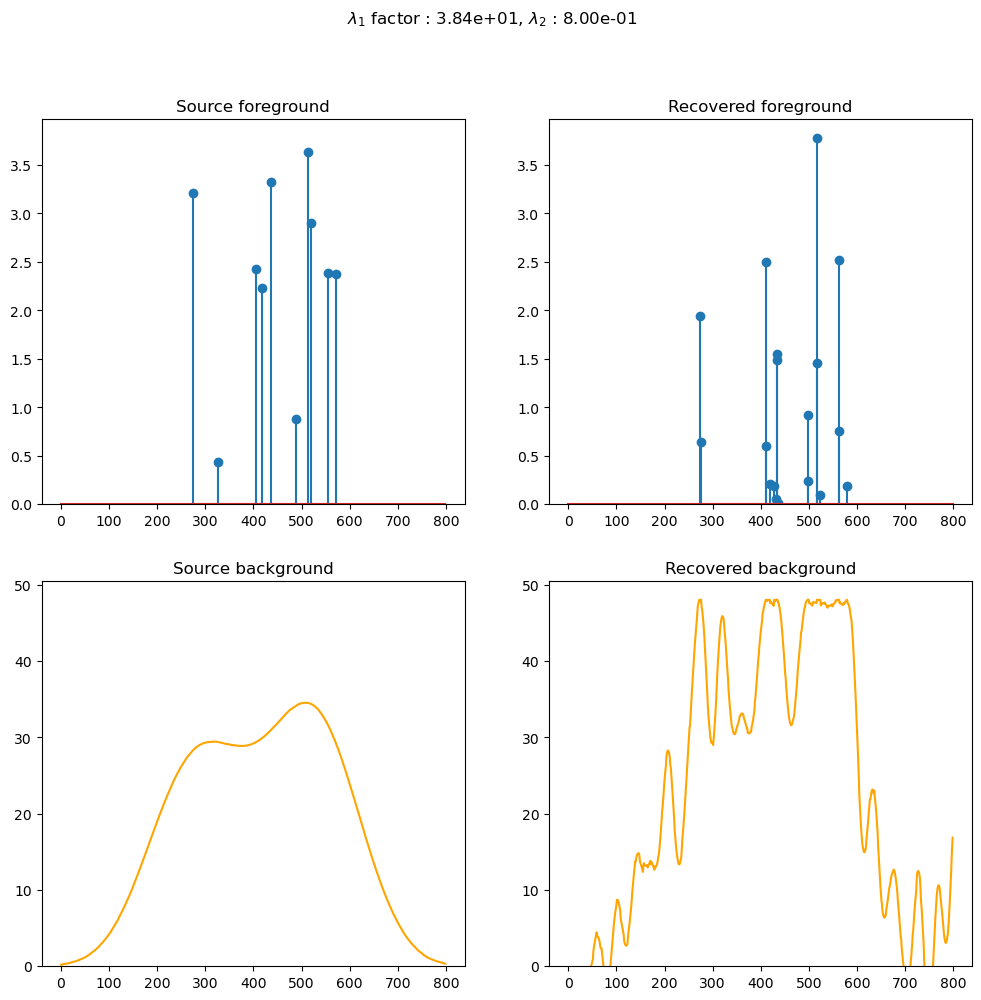

In [782]:
plt.figure(figsize=(12, 11))
plt.suptitle(rf"$\lambda_1$ factor : {lambda1:.2e}, $\lambda_2$ : {lambda2:.2e}")
ylim = max(img.max(), x1.max())
# plt.subplot(421)
plt.subplot(221)
plt.ylim(top=1.05 * ylim)
plt.stem(np.arange(img.shape[0])[img != 0], img[img != 0])
plt.stem([0, Ngrid-1], [0, 0], markerfmt='white')
plt.title("Source foreground")
# plt.subplot(422)
plt.subplot(222)
plt.ylim(top=1.05 * ylim)
plt.stem(np.arange(x1.shape[0])[x1 != 0], x1[x1 != 0])
plt.stem([0, Ngrid-1], [0, 0], markerfmt='white')
plt.title("Recovered foreground")

ylim = max(background.max(), x2.max())
# plt.subplot(423)
plt.subplot(223)
plt.ylim(top=1.05 * ylim)
# plt.stem(background)
plt.plot(np.arange(Ngrid), background, c='orange',)  # marker='.')
plt.title("Source background")
# plt.subplot(424)
plt.subplot(224)
plt.ylim(top=1.05 * ylim)
# plt.stem(x2)
plt.plot(np.arange(Ngrid), x2, c='orange',)  # marker='.')
plt.title("Recovered background")

In [783]:
repr_std = 1.5
representation_kernel = 1/(np.sqrt(2 * np.pi * repr_std**2)) * np.exp(-0.5 * np.arange(-3 * repr_std, 3 * repr_std + 1)**2 / repr_std**2)


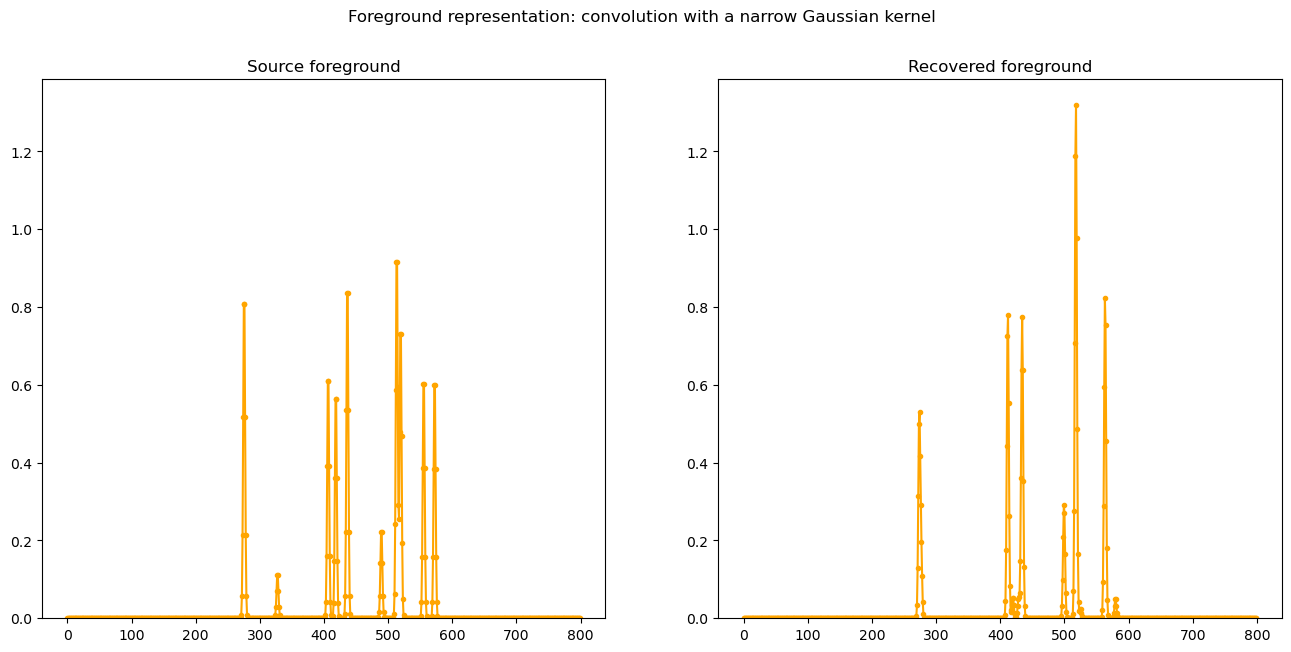

In [784]:
fig = plt.figure(figsize=(16, 7))
plt.suptitle("Foreground representation: convolution with a narrow Gaussian kernel")
repr_source = np.convolve(img, representation_kernel, mode='same')
repr_recovered = np.convolve(x1, representation_kernel, mode='same')
# repr_ndcp = np.convolve(x1_ndcp, representation_kernel, mode='same')
# repr_blasso = np.convolve(x_blasso, representation_kernel, mode='same')
ylim = max(repr_source.max(), repr_recovered.max(),)  # repr_ndcp.max())
axes = fig.subplots(1, 2, sharex=True)
ax = axes.ravel()[0]
ax.set_ylim(top=1.05 * ylim)
ax.plot(np.arange(Ngrid), repr_source, c='orange', marker='.')
ax.set_title("Source foreground")
ax = axes.ravel()[1]
ax.set_ylim(top=1.05 * ylim)
ax.plot(np.arange(Ngrid), repr_recovered, c='orange', marker='.')
ax.set_title("Recovered foreground")
# ax = axes.ravel()[2]
# ax.set_ylim(top=1.05 * ylim)
# ax.plot(np.arange(Ngrid), repr_ndcp, c='orange', marker='.')
# ax.set_title("Non-decoupled foreground")
# ax = axes.ravel()[3]
# ax.set_ylim(top=1.05 * ylim)
# ax.plot(np.arange(Ngrid), repr_blasso, c='orange', marker='.')
# ax.set_title("BLASSO foreground")
plt.show()